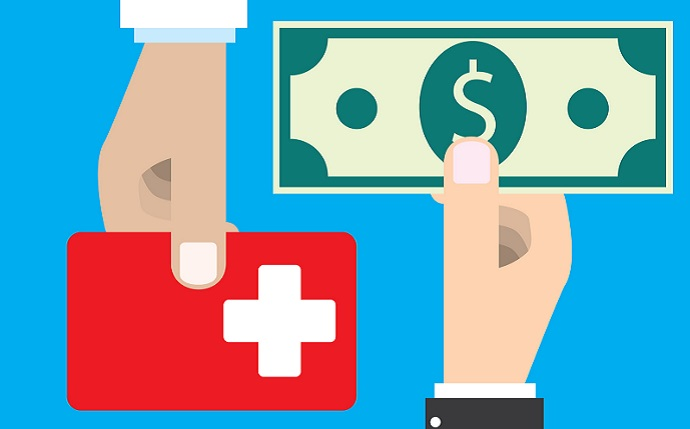

# Tratamento e Exploração de Dados

### Custos médicos

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
dados = pd.read_csv('../input/insurance/insurance.csv')
dados.head()

In [ ]:
dados.isnull().sum()

In [ ]:
dados.info()

In [ ]:
for i in dados.select_dtypes(include='object').columns:
  print(dados[i].value_counts())

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

#### Transformação de dados categoricos em numéricos

In [ ]:
encoder = LabelEncoder()

In [ ]:
dados['sex'] = encoder.fit_transform(dados.sex)
dados['smoker'] = encoder.fit_transform(dados.smoker)

In [ ]:
dados = dados.join(pd.get_dummies(dados.region))

In [ ]:
dados.drop('region', axis=1, inplace=True)
dados.head()

#### Criação de nova variável relacionada ao índice de massa corporal, onde 1 corresponde a um IMC saudável, e 0 corresponde a um IMC não saudável.

In [ ]:
x = []
for n in dados['bmi']:
  if n > 18.5 or n < 24.9:
    x.append(1)
  if n < 18.5 or n > 24.9:
    x.append(0)

In [ ]:
x = pd.DataFrame(x)
x = x.astype("float")

In [ ]:
dados['bmi2'] = x

In [ ]:
dados.head()

In [ ]:
dados['bmi2'] = dados.bmi2.astype('int')

In [ ]:
ax, fig = plt.subplots(figsize=(12,6))
sns.heatmap(dados.corr(), annot=True).set_title("Correlation map", size=17)

In [ ]:
for n in dados.columns:
  print(n,":", dados['charges'].corr(dados[n]))

In [ ]:
columns = []
for n in dados.columns:
  if dados['charges'].corr(dados[n]) > 0.15:
    columns.append(n)

data = dados.loc[:,columns]

In [ ]:
data.head()

In [ ]:
sns.pairplot(data)

### Aplicação de algoritmos de machine learning para prever o custo médico

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [ ]:
x = data.iloc[:,0:3]
y = data.iloc[:,3]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

### Árvores de decisão

In [ ]:
modelo1 = DecisionTreeRegressor()
modelo1.fit(x_train, y_train)
predicao1 = modelo1.predict(x_test)

In [ ]:
print("MAE :", mean_absolute_error(y_test, predicao1))
print("Média predição :", predicao1.mean())
print("Média val. reais :", y_test.mean())

### Random Forest

In [ ]:
modelo2 = RandomForestRegressor()
modelo2.fit(x_train, y_train)
predicao2 = modelo2.predict(x_test)

In [ ]:
print("MAE :", mean_absolute_error(y_test, predicao2))
print("Média predição :", predicao2.mean())
print("Média val. reais :", y_test.mean())

### KMeans - clustering

In [ ]:
scaler = StandardScaler()

In [ ]:
data_scaler = scaler.fit_transform(data)

#### Elbow Method

In [ ]:
K = range(1,16)
valores = []
for k in K:
  kmean = KMeans(n_clusters=k)
  kmean.fit(data_scaler)
  valores.append(kmean.inertia_)

In [ ]:
plt.subplots(figsize=(12,6))
plt.plot(K, valores, '--')
plt.title("Elbow Method")
plt.show()

In [ ]:
clustering = KMeans(n_clusters=3)
clustering.fit(data_scaler)

In [ ]:
predicao3 = clustering.labels_
centroides = clustering.cluster_centers_

#### Aplicação do PCA para facilitar a vizualização dos dados

In [ ]:
centroides

In [ ]:
pca = PCA(n_components=2)
dados_pca = pca.fit_transform(data_scaler)
dados_pca = pd.DataFrame(dados_pca, columns=['pca1', 'pca2'])
dados_pca = pd.concat([dados_pca, pd.DataFrame({'grupos' : predicao3, "charge" : data.charges})], axis = 1)

In [ ]:
dados_pca.head()

In [ ]:
from matplotlib.patches import Ellipse

In [ ]:
ax, fig = plt.subplots(figsize=(12,6))
sns.scatterplot(x=dados_pca.pca1, y=dados_pca.pca2, hue=dados_pca.grupos, size=dados_pca.charge)
plt.title("Clustering", size=17, style='oblique', fontweight='bold')
##remove spines
fig.spines["right"].set_visible(False)
fig.spines['top'].set_visible(False)
fig.spines['left'].set_visible(False)
fig.spines['bottom'].set_visible(False)
##remove labels
fig.axis(False)
plt.show()

### Modelo de regressão

In [ ]:
import statsmodels.api as sm

In [ ]:
x_reg = sm.add_constant(x, prepend=False)

In [ ]:
modelo4 = sm.OLS(endog=y, exog=x_reg)
res = modelo4.fit()

In [ ]:
print(res.summary())

In [ ]:
x_reg_test = sm.add_constant(x_test, prepend=False)

In [ ]:
predicao4 = res.predict(x_reg_test)

In [ ]:
print("MAE :", mean_absolute_error(y_test, predicao4))
print("Média predição :", predicao4.mean())
print("Média val. reais :", y_test.mean())